In [114]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [115]:
import numpy as np
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

print("Path to dataset files:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path = os.path.join(path, "sprites.npy")

# load dataset
labels = np.load(labels_path)
data = np.load(data_path)

print("Shape: ", data.shape)

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Device:  cuda:0


In [116]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([32, 3, 16, 16]) torch.Size([32, 5])


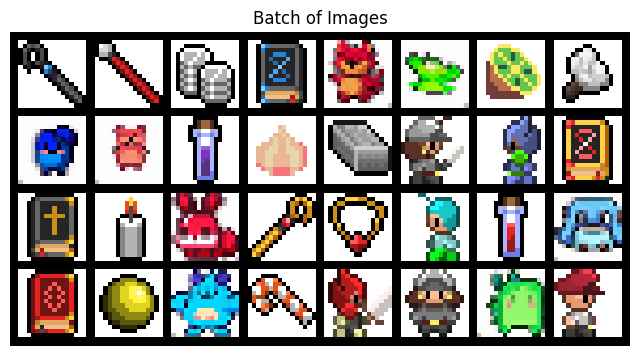

In [117]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

#### DC + Conditional GAN

Hyperparameter

In [118]:
workers = 2
batch_size = 32
nc = 3  # number of color channels
z_dim = 100  # latent vector size
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1
ngf = 32  # generator feature maps
ndf = 32  # discriminator feature maps
num_classes = 5  # number of classes for conditional GAN

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Weight Initialization

In [119]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

In [120]:
class Generator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        # label embedding
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.gen = nn.Sequential(
            # input: (z_dim + num_classes) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=z_dim + num_classes,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # 4x4 → 8x8
            nn.ConvTranspose2d(
                ngf * 8, ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 8x8 → 16x16
            nn.ConvTranspose2d(
                ngf * 4, nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # labels → embedding
        label_emb = self.label_emb(labels)

        # reshape to match noise (B, C, 1, 1)
        label_emb = label_emb.unsqueeze(2).unsqueeze(3)

        # concatenate noise + label
        x = torch.cat([noise, label_emb], dim=1)

        return self.gen(x)

In [121]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        # label embedding → map label to 16x16
        self.label_emb = nn.Embedding(num_classes, 16 * 16)

        self.disc = nn.Sequential(
            # input: (nc + 1) x 16 x 16
            nn.Conv2d(
                in_channels=nc + 1,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8
            nn.Conv2d(
                ndf, ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4 → 1x1
            nn.Conv2d(
                ndf * 2, 1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        # labels → embedding
        label_map = self.label_emb(labels)

        # reshape to (B, 1, 16, 16)
        label_map = label_map.view(labels.size(0), 1, 16, 16)

        # concatenate image + label
        x = torch.cat([images, label_map], dim=1)

        return self.disc(x)

In [122]:
netG = Generator(ngpu, num_classes).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

netD = Discriminator(ngpu, num_classes).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Generator(
  (label_emb): Embedding(5, 5)
  (gen): Sequential(
    (0): ConvTranspose2d(105, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
Discriminator(
  (label_emb): Embedding(5, 256)
  (disc): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU

Loss and Optimizer

In [123]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# ============================================
# INITIALIZE TRAINING VARIABLES
# ============================================
# Fixed noise for visualization
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Loss tracking
G_losses = []
D_losses = []
img_list = []

# Labels
real_label = 0.9
fake_label = 0.1

Training Loop

In [124]:
print("Starting Training Loop...")

iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network
        ############################
        netD.zero_grad()

        # real batch
        real_cpu, real_labels = data
        real_cpu = real_cpu.to(device)

        # Get batch size
        b_size = real_cpu.size(0)

        # Convert one-hot labels to class indices
        real_labels = real_labels.to(device)
        if real_labels.dim() > 1 and real_labels.size(1) == num_classes:
            real_labels = torch.argmax(real_labels, dim=1)
        real_labels = real_labels.long()

        # Real labels (smoothed)
        label = torch.full((b_size,), real_label, dtype=torch.float32, device=device)

        # Forward real batch through D
        output = netD(real_cpu, real_labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ############################
        # Fake batch
        ############################
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = netG(noise, real_labels)
        def add_noise(images, std=0.1):
            noise = torch.randn_like(images) * std
            return images + noise

        label.fill_(fake_label)
        output = netD(add_noise(real_cpu), real_labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()

        label.fill_(real_label)
        output = netD(add_noise(fake.detach()), real_labels).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        ############################
        # Logs
        ############################
        if i % 50 == 0:
            print(
                f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] "
                f"Loss_D: {errD.item():.4f} "
                f"Loss_G: {errG.item():.4f} "
                f"D(x): {D_x:.4f} "
                f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
            )

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        ############################
        # Visualization
        ############################
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(loader) - 1)):
            with torch.no_grad():
                fixed_labels = torch.randint(0, num_classes, (64,), device=device).long()
                fake_vis = netG(fixed_noise, fixed_labels).detach().cpu()

            img_list.append(vutils.make_grid(fake_vis, padding=2, normalize=True))

        iters += 1

print("Training Complete!")

Starting Training Loop...
[1/5][0/2794] Loss_D: 1.4126 Loss_G: 0.6224 D(x): 0.5376 D(G(z)): 0.5376/0.5627
[1/5][50/2794] Loss_D: 1.3897 Loss_G: 0.5494 D(x): 0.4842 D(G(z)): 0.4842/0.6078
[1/5][100/2794] Loss_D: 1.3875 Loss_G: 0.5871 D(x): 0.4950 D(G(z)): 0.4950/0.5792
[1/5][150/2794] Loss_D: 1.3876 Loss_G: 0.5724 D(x): 0.5066 D(G(z)): 0.5066/0.5902
[1/5][200/2794] Loss_D: 1.3869 Loss_G: 0.5687 D(x): 0.4977 D(G(z)): 0.4977/0.5966
[1/5][250/2794] Loss_D: 1.3867 Loss_G: 0.5336 D(x): 0.5027 D(G(z)): 0.5027/0.6240
[1/5][300/2794] Loss_D: 1.3875 Loss_G: 0.5729 D(x): 0.4857 D(G(z)): 0.4857/0.5953
[1/5][350/2794] Loss_D: 1.3866 Loss_G: 0.5649 D(x): 0.5010 D(G(z)): 0.5010/0.6004
[1/5][400/2794] Loss_D: 1.3872 Loss_G: 0.5539 D(x): 0.4870 D(G(z)): 0.4870/0.6075
[1/5][450/2794] Loss_D: 1.3866 Loss_G: 0.5560 D(x): 0.5009 D(G(z)): 0.5009/0.6017
[1/5][500/2794] Loss_D: 1.3868 Loss_G: 0.5661 D(x): 0.4916 D(G(z)): 0.4916/0.6008
[1/5][550/2794] Loss_D: 1.3871 Loss_G: 0.5598 D(x): 0.5110 D(G(z)): 0.5111/

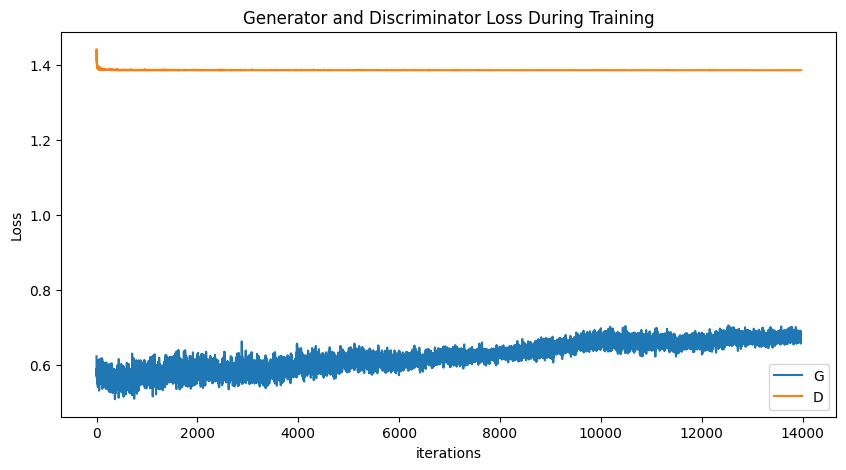

In [125]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

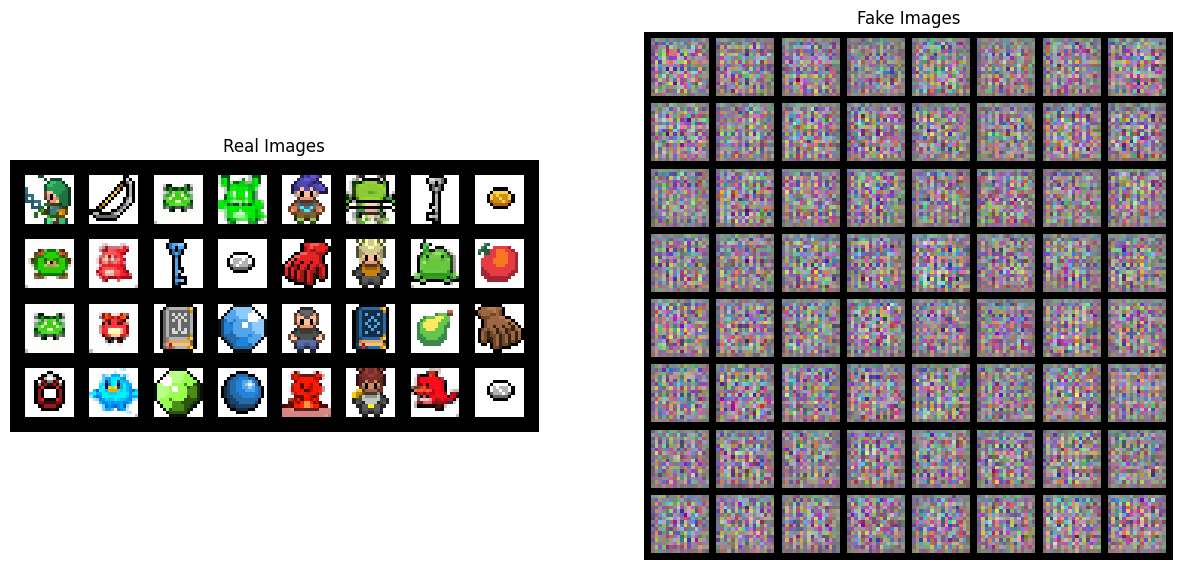

In [126]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

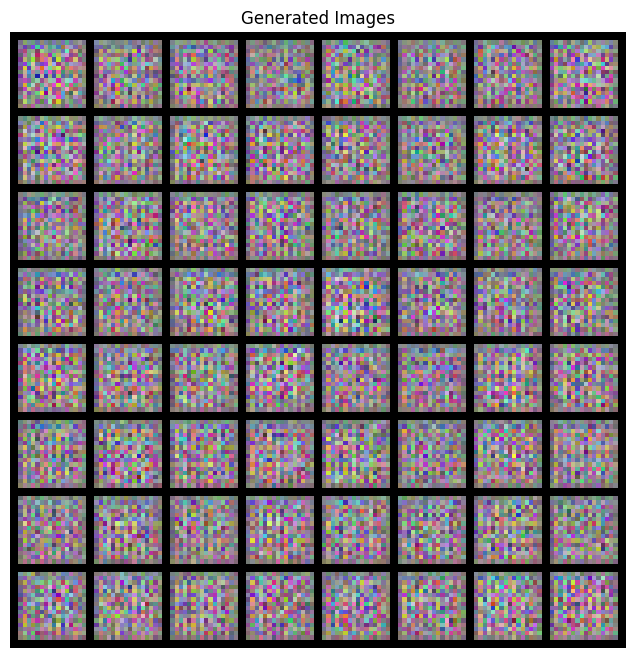

In [127]:
# Show generated images
if len(img_list) > 0:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(img_list[-1].permute(1, 2, 0))
    plt.show()